In [38]:
import os
import sys

import copy
import numpy as np
from astropy.cosmology import Planck18

PACKAGE_PARENT = '..'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd())))
sys.path.append(SCRIPT_DIR)
import gwfast.gwfastGlobals as glob
import gwfast 
from gwfast.waveforms import IMRPhenomD_NRTidalv2
from gwfast.signal import GWSignal
from gwfast.network import DetNet
from fisherTools import CovMatr, compute_localization_region, check_covariance, fixParams
from gwfastUtils import GPSt_to_LMST, Lamt_delLam_from_Lam12

In [2]:
keys = ('Mc','eta','dL','theta','phi','iota','psi','tcoal','Phicoal','chi1x','chi2x',
        'chi1y','chi2y','chi1z','chi2z','LambdaTilde','deltaLambda','ecc')
mydata=dict.fromkeys(keys)
alldetectors = copy.deepcopy(glob.detectors)
print('All available detectors are: '+str(list(alldetectors.keys())))

# select only LIGO and Virgo
LVdetectors = {det:alldetectors[det] for det in ['L1', 'H1', 'Virgo']}
print('Using detectors '+str(list(LVdetectors.keys())))
# We use the O2 psds
LVdetectors['L1']['psd_path'] = os.path.join(glob.detPath, 'LVC_O1O2O3', '2017-08-06_DCH_C02_L1_O2_Sensitivity_strain_asd.txt')
LVdetectors['H1']['psd_path'] = os.path.join(glob.detPath, 'LVC_O1O2O3', '2017-06-10_DCH_C02_H1_O2_Sensitivity_strain_asd.txt')
LVdetectors['Virgo']['psd_path'] = os.path.join(glob.detPath, 'LVC_O1O2O3', 'Hrec_hoft_V1O2Repro2A_16384Hz.txt')


All available detectors are: ['L1', 'H1', 'Virgo', 'KAGRA', 'LIGOI', 'ETS', 'ETMR', 'ETSL', 'ETMRL45d', 'ETMRLpar', 'CE1Id', 'CE2NM', 'CE2NSW']
Using detectors ['L1', 'H1', 'Virgo']


In [3]:
myLVSignals = {}

for d in LVdetectors.keys():

    myLVSignals[d] = GWSignal(IMRPhenomD_NRTidalv2(),
                psd_path=LVdetectors[d]['psd_path'],
                detector_shape = LVdetectors[d]['shape'],
                det_lat= LVdetectors[d]['lat'],
                det_long=LVdetectors[d]['long'],
                det_xax=LVdetectors[d]['xax'],
                verbose=True,
                useEarthMotion = False,
                fmin=10.,
                IntTablePath=None)

myLVNet = DetNet(myLVSignals)

Using ASD from file /home/rciancarella/.local/lib/python3.10/site-packages/psds/LVC_O1O2O3/2017-08-06_DCH_C02_L1_O2_Sensitivity_strain_asd.txt 
Initializing jax...
Jax local device count: 8
Jax  device count: 8
Using ASD from file /home/rciancarella/.local/lib/python3.10/site-packages/psds/LVC_O1O2O3/2017-06-10_DCH_C02_H1_O2_Sensitivity_strain_asd.txt 
Initializing jax...
Jax local device count: 8
Jax  device count: 8
Using ASD from file /home/rciancarella/.local/lib/python3.10/site-packages/psds/LVC_O1O2O3/Hrec_hoft_V1O2Repro2A_16384Hz.txt 
Initializing jax...
Jax local device count: 8
Jax  device count: 8


In [4]:
# Median values of the posterior samples for all the parameters,
# except psi and the coalescence phase that are set to 0

z = np.array([0.00980])
tGPS = np.array([1187008882.4])

GW170817 = {'Mc':np.array([1.1859])*(1.+z),
            'dL':Planck18.luminosity_distance(z).value/1000.,
            'theta':np.array([np.pi/2. + 0.4080839999999999]),
            'phi':np.array([3.4461599999999994]),
            'iota':np.array([2.545065595974997]),
            'psi':np.array([0.]),
            'tcoal':GPSt_to_LMST(tGPS, lat=0., long=0.), # GMST is LMST computed at long = 0°
            'eta':np.array([0.24786618323504223]),
            'Phicoal':np.array([0.]),
            'chi1z':np.array([0.005136138323169717]),
            'chi2z':np.array([0.003235146993487445]),
            'Lambda1':np.array([368.17802383555687]),
            'Lambda2':np.array([586.5487031450857])
           }

print('Parameters for GW170817 are:')
GW170817

Parameters for GW170817 are:


{'Mc': array([1.19752182]),
 'dL': array([0.04374755]),
 'theta': array([1.97888033]),
 'phi': array([3.44616]),
 'iota': array([2.5450656]),
 'psi': array([0.]),
 'tcoal': DeviceArray([0.43432288], dtype=float64),
 'eta': array([0.24786618]),
 'Phicoal': array([0.]),
 'chi1z': array([0.00513614]),
 'chi2z': array([0.00323515]),
 'Lambda1': array([368.17802384]),
 'Lambda2': array([586.54870315])}

In [5]:
SNR = myLVNet.SNR(GW170817)
print('SNR for GW170817 is %.2f to compare with 33'%SNR[0])

SNR for GW170817 is 33.16 to compare with 33


In [6]:
totF = myLVNet.FisherMatr(GW170817)
print('The computed Fisher matrix has shape %s'%str(totF.shape))

Computing Fisher for L1...
Computing derivatives...
Computing Fisher for H1...
Computing derivatives...
Computing Fisher for Virgo...
Computing derivatives...
Done.
The computed Fisher matrix has shape (13, 13, 1)


In [7]:
ParNums = IMRPhenomD_NRTidalv2().ParNums
#tofix_ParNums=[e for e in ParNums if e not in ('dL', 'phi','theta')]
newFish, newPars = fixParams(totF, ParNums, ['deltaLambda'])
#newFish, newPars = fixParams(totF, ParNums, tofix_ParNums)
print('Now the Fisher matrix has shape %s'%str(newFish.shape))

newCov, new_inversion_err = CovMatr(newFish)

_ = check_covariance(newFish, newCov)

Now the Fisher matrix has shape (12, 12, 1)
Inversion errors: [0.00030831]
diagonal-1 = [array([-4.54829951e-10, -1.78643766e-09, -9.34453795e-13,  1.48501003e-14,
        2.56035319e-13, -8.07555303e-13, -5.37078281e-12,  5.18435364e-10,
       -3.58276742e-11,  7.52511337e-07,  6.57836786e-07, -8.88275564e-12],
      dtype=float128)]
Max off diagonal: [0.00030830537434667348862]

mask: where F*S(off-diagonal)>1e-10 (--> problematic if True off diagonal)
[array([[ True, False, False, False, False, False, False, False, False,
        False, False, False],
       [ True,  True, False, False, False, False, False,  True, False,
        False,  True, False],
       [False, False,  True, False, False, False, False, False, False,
        False, False, False],
       [False,  True, False,  True, False, False, False, False, False,
        False, False, False],
       [ True, False, False, False,  True, False, False, False, False,
        False, False, False],
       [False,  True, False, False

In [8]:
skyArea = compute_localization_region(newCov, newPars, GW170817['theta'])
print('The estimated sky location is %.1f deg^2, to compare with 16 deg^2'%skyArea)

The estimated sky location is 19.9 deg^2, to compare with 16 deg^2


In [36]:
print(ParNums)

{'Mc': 0, 'eta': 1, 'dL': 2, 'theta': 3, 'phi': 4, 'iota': 5, 'psi': 6, 'tcoal': 7, 'Phicoal': 8, 'chi1z': 9, 'chi2z': 10, 'LambdaTilde': 11, 'deltaLambda': 12}


In [9]:
print(newPars)

{'Mc': 0, 'eta': 1, 'dL': 2, 'theta': 3, 'phi': 4, 'iota': 5, 'psi': 6, 'tcoal': 7, 'Phicoal': 8, 'chi1z': 9, 'chi2z': 10, 'LambdaTilde': 11}


In [40]:
lambtilde,d_lamb=Lamt_delLam_from_Lam12(GW170817['Lambda1'][0],GW170817['Lambda2'][0],GW170817['eta'][0])

In [41]:
print(lambtilde)

456.2163206808929


# Check with proxygen

In [31]:
import pandas as pd
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

from astropy.cosmology import FlatLambdaCDM
from astropy.table import Table

from ligo.skymap.io import fits
from ligo.skymap.postprocess import find_greedy_credible_levels

import os
import sys
from tqdm import tqdm

import h5py
from multiprocessing import Pool
import pickle
from numba import jit

H0GLOB=67 #69
Om0GLOB=0.319
Xi0Glob =1.
clight = 2.99792458* 10**5#km/s
cosmoflag = FlatLambdaCDM(H0=H0GLOB, Om0=Om0GLOB)

        Use get instead. [ligo.skymap.postprocess.cosmology]
        Use get instead.


In [69]:
def area(nside,all_pixels,p_posterior,level=0.95):

    
    ''' Area of level% credible region, in square degrees.
        If level is not specified, uses current selection '''
    pixarea=hp.nside2pixarea(nside)
    return get_credible_region_pixels(all_pixels,p_posterior,level=level).size*pixarea*(180/np.pi)**2


def _get_credible_region_pth(p_posterior,level=0.95):
    '''
    Finds value minskypdf of rho_i that bouds the x% credible region , with x=level
    Then to select pixels in that region: self.all_pixels[self.p_posterior>minskypdf]
    '''
    prob_sorted = np.sort(p_posterior)[::-1]
    prob_sorted_cum = np.cumsum(prob_sorted)
    # find index of array which bounds the area confidence interval
    idx = np.searchsorted(prob_sorted_cum, level)
    minskypdf = prob_sorted[idx] #*skymap.npix
      
    return minskypdf

def get_credible_region_pixels(all_pixels, p_posterior, level=0.95):

    return all_pixels[p_posterior>_get_credible_region_pth(p_posterior,level=level)]

def sample_multivariate_gaussian(mean, cov, num_samples):
    return np.random.multivariate_normal(mean, cov, num_samples)

def process_pixel(args):
    pix, nside, mean, cov, new_samples_per_pixel, samples, pixels = args
    
    # Get the fixed angles for this pixel
    theta_fixed, phi_fixed = hp.pix2ang(nside, pix)
    
    # Extract samples of all parameters for this pixel
    pixel_indices = np.where(pixels == pix)[0]
    samples_in_pixel = samples[pixel_indices]

    # Permutation order to move luminosity distance to index 0, theta to index 1, and phi to index 2
    perm = [2, 3, 4] + list(range(0, 2)) + list(range(5, len(mean)))

    # Apply the permutation to the mean and covariance matrix
    mean_permuted = np.array(mean)[perm]
    cov_permuted = cov[np.ix_(perm, perm)]

# Create the alpha vector with the fixed values and mean of other parameters
    alpha = np.zeros(len(mean_permuted) - 1)
    alpha[0] = theta_fixed
    alpha[1] = phi_fixed
    alpha[2:] = samples_in_pixel[:, [0, 1, 5, 6,7,8,9,10,11]].mean(axis=0)  # Use the mean of the other parameters in this pixel
    
    # Create a new mean vector excluding the luminosity distance mean (mean_permuted[0])
    mean_new = mean_permuted[1:]

    # Partition the permuted covariance matrix
    Sigma_xx = cov_permuted[1:, 1:]
    Sigma_xy = cov_permuted[1:, 0]
    Sigma_yx = cov_permuted[0, 1:]
    Sigma_yy = cov_permuted[0, 0]
    
    # Compute the conditional mean and covariance
    mu_cond = mean_permuted[0] + Sigma_yx @ np.linalg.inv(Sigma_xx) @ (alpha - mean_new)
    Sigma_cond = Sigma_yy - Sigma_yx @ np.linalg.inv(Sigma_xx) @ Sigma_xy
    
    # Handle negative Sigma_cond
    if Sigma_cond < 0:
        print(f"Warning: Negative Sigma_cond ({Sigma_cond}) encountered for pixel {pix}.")
        Sigma_cond = np.abs(Sigma_cond)  # Take the absolute value
        Sigma_cond = max(Sigma_cond, 1e-10)  # Ensure it is at least a small positive value
    
    # Sample from the conditional Gaussian distribution
    new_samples = np.random.normal(mu_cond, np.sqrt(Sigma_cond), new_samples_per_pixel)
    
    # Extract the new luminosity distances
    new_luminosity_distance = new_samples
    
    # Compute the mean and std of the luminosity distance
    mu = np.mean(new_luminosity_distance)
    std = np.std(new_luminosity_distance)
    
    return pix, mu, std, new_luminosity_distance


In [70]:
mean=[]
avoid=['Lambda1','Lambda2']
for k in GW170817.keys():
    if k not in avoid:
        mean.append(GW170817[k][0])
mean.append(lambtilde)    
mean=np.array(mean)
print(mean,len(mean))
cov=np.float64(newCov[:,:,0])
#print(cov)

[1.19752182e+00 4.37475545e-02 1.97888033e+00 3.44616000e+00
 2.54506560e+00 0.00000000e+00 4.34322878e-01 2.47866183e-01
 0.00000000e+00 5.13613832e-03 3.23514699e-03 4.56216321e+02] 12


In [71]:
print(np.shape(mean),np.shape(cov))

(12,) (12, 12)


In [ ]:
num_samples = 500_000_000

# Sample from the multivariate Gaussian distribution
samples = sample_multivariate_gaussian(mean, cov, num_samples)

# Extract variables
luminosity_distance = samples[:, 2]
#angles = samples[:, 3:5]
theta=samples[:,3]
phi=samples[:,4]
# Ensure angles are within valid ranges
#angles[:, 0] = np.mod(angles[:, 0], np.pi)  # theta in range [0, π]
theta = np.mod(theta, np.pi)  # theta in range [0, π]
#angles[:, 1] = np.mod(angles[:, 1], 2 * np.pi)  # phi in range [0, 2π]
phi = np.mod(phi, 2 * np.pi)  # phi in range [0, 2π]

# Number of pixels in the sky map
nside = 64

# Create a HEALPix map
sky_map = np.zeros(hp.nside2npix(nside))
npix=hp.nside2npix(nside)
all_pixels=np.arange(npix)
# Convert angles to pixel indices
pixels = hp.ang2pix(nside, theta, phi)

# Increment the pixel values
np.add.at(sky_map, pixels, 1)

# Normalize the sky map
sky_map = sky_map / np.sum(sky_map)

# Get the array of good pixels where sky_map > 0
pix95=get_credible_region_pixels(all_pixels,sky_map)
pix90=get_credible_region_pixels(all_pixels,sky_map,level=0.9)
# Initialize arrays to store the mean and std of luminosity distance
all_mu = np.zeros(hp.nside2npix(nside))
all_std = np.zeros(hp.nside2npix(nside))

# Initialize dictionary to store new luminosity distance arrays for each pixel
luminosity_distance_samples = {}

# Number of new samples to generate for each pixel
new_samples_per_pixel = 1_000

# Prepare arguments for multiprocessing
args = [(pix, nside, mean, cov, new_samples_per_pixel, samples, pixels) for pix in pix95]

# Specify the number of processors to use
num_processors = 10

# Using multiprocessing Pool to parallelize the process
with Pool(processes=num_processors) as pool:
    # Using tqdm to add a progress bar
    results = list(tqdm(pool.imap(process_pixel, args), total=len(pix95)))

# Collect the results
for pix, mu, std, new_luminosity_distance in results:
    if mu is not None and std is not None:
        all_mu[pix] = mu
        all_std[pix] = std
        luminosity_distance_samples[pix] = new_luminosity_distance

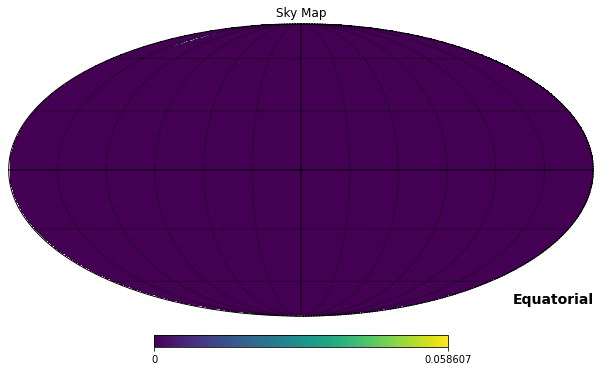

In [67]:
# Plot the sky map
hp.mollview(sky_map, title="Sky Map", coord=['C'])
hp.graticule()
plt.show()

In [ ]:
myarea=area(nside,all_pixels,sky_map,level=0.90)
print(myarea)